In [ ]:
import pandas as pd
import networkx as nx
import random
import matplotlib.pyplot as plt
import math
import colorsys

In [ ]:
filePath    = "Airports2.csv"
yearList    = ['1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009']
states      = ["CA", "NY", "TX", "FL", 'OR', "PA", 'KS']
percentage  = 1

data = pd.read_csv(filePath)
data = data.dropna()

# creates the sample size
sample = data.sample(int(percentage*len(data)))

# gets the source and dest states of each flight
sample['Source_state'] = sample['Origin_city'].apply( lambda x: x.split(', ')[1])
sample['Dest_state']   = sample['Destination_city'].apply(lambda x: x.split(', ')[1])

# gets the years and months of flights
sample['Year']  = sample['Fly_date'].apply(lambda x: x.split('-')[0])
sample          = sample[sample['Year'].isin(yearList)]
sample['Month'] = sample['Fly_date'].apply(lambda x: int(x.split('-')[1]))

# If stateSet not given creates it based on the states in the sample
if states == None:
    sourceStateSet  = set(sample['Source_state'].drop_duplicates())
    destStateSet    = set(sample['Dest_state'].drop_duplicates())
    state        = sourceStateSet.union(destStateSet)

#limits flights looked at based upon stateSet
cond    = (sample['Source_state'].isin(states) & sample['Dest_state'].isin(states))
sample  = sample[cond]

# Creates dictionary (airport_state) where keys are the airports
# and the values are the state associated with it
source_pairs         = sample[['Origin_airport', 'Source_state']].drop_duplicates()
dest_pairs           = sample[['Destination_airport','Dest_state']].drop_duplicates()
source_pairs.columns = ['Airport', 'State']
dest_pairs.columns   = ['Airport', 'State']
unique_pairs         = pd.concat([source_pairs, dest_pairs], axis=0).drop_duplicates()
airport_state        = unique_pairs.set_index('Airport')['State']

# gets unique airports in sample
source_apts         = sample['Origin_airport'].drop_duplicates()
dest_apts           = sample['Destination_airport'].drop_duplicates()
source_apts.columns = ['Airport']
dest_apts.columns   = ['Airport']
unique_airports     = pd.concat([source_apts, dest_apts], axis=0).drop_duplicates()

# Creates a dict (arpt_count) that associates every airport with it's y-coordinate
arpt_count = {}
i = 0
for airport in unique_airports:
    arpt_count[airport] = i
    i += 1




In [ ]:
sample.head()

Origin_airport Destination_airport          Origin_city  \
1680928            MIA                 JFK            Miami, FL   
147045             FLL                 TPA  Fort Lauderdale, FL   
2665101            SFO                 PIT    San Francisco, CA   
3386907            JFK                 PHL         New York, NY   
2345542            AUS                 SAN           Austin, TX   

         Destination_city  Passengers  Seats  Flights  Distance    Fly_date  \
1680928      New York, NY         579   1068        6      1090  1992-12-01   
147045          Tampa, FL       18194  26715      195       197  2007-06-01   
2665101    Pittsburgh, PA        8704  14014       77      2253  1999-02-01   
3386907  Philadelphia, PA         570   1400       28        94  2008-04-01   
2345542     San Diego, CA        2648   2806       23      1164  2008-07-01   

         Origin_population  Destination_population  Org_airport_lat  \
1680928            8451688                33861848        25.793200   
147045             5465183                 2711222        26.072599   
2665101            8068740                 2404337        37.618999   
3386907           37937002                11880992        40.639801   
2345542            1654100                 3019274        30.194500   

         Org_airport_long  Dest_airport_lat  Dest_airport_long Source_state  \
1680928        -80.290604         40.639801         -73.778900           FL   
147045         -80.152702         27.975500         -82.533203           FL   
2665101       -122.375000         40.491501         -80.232903           CA   
3386907        -73.778900         39.871899         -75.241096           NY   
2345542        -97.669899         32.733601        -117.190002           TX   

        Dest_state  Year  Month  
1680928         NY  1992     12  
147045          FL  2007      6  
2665101         PA  1999      2  
3386907         PA  2008      4  
2345542         CA  2008      7

In [ ]:
# def removeOutliersKamada(Graph, Position):
#     # Calculate standard deviation of y
#     y_coords = [pos[1] for pos in Position.values()]
#     y_coords = list(y_coords) #Convert it to a list because otherwise Python doesn't like it.
#     y_mean = sum(y_coords) / len(y_coords)
#     y_std_dev = math.sqrt(sum((y - y_mean) ** 2 for y in y_coords) / len(y_coords))

#     # Threshold for outliers
#     y_threshold = 1 * y_std_dev

#     # Keys to Remove
#     keys_to_remove = []
#     for key, pos in Position.items():
#         y = pos[1]
#         if abs(y - y_mean) > y_threshold:
#             keys_to_remove.append(key)
#     if len(keys_to_remove) == 0:
#       return Position
#     # Remove nodes
#     for key in keys_to_remove:
#         Graph.remove_node(key)
#     return removeOutliersKamada(Graph, nx.kamada_kawai_layout(Graph))


In [ ]:
def removeOutliersSpring(Graph, Position, sample):
    # Calculate standard deviation of y
    y_coords = [pos[1] for pos in Position.values()]
    y_coords = list(y_coords) #Convert it to a list because otherwise Python doesn't like it.
    y_mean = sum(y_coords) / len(y_coords)
    y_std_dev = math.sqrt(sum((y - y_mean) ** 2 for y in y_coords) / len(y_coords))

    # Threshold for outliers
    y_threshold = 3 * y_std_dev

    # Keys to Remove
    keys_to_remove = []
    for key, pos in Position.items():
        y = pos[1]
        if abs(y - y_mean) > y_threshold:
            print(key)
            keys_to_remove.append(key)
    if len(keys_to_remove) == 0:
      return Position, sample
    # Remove nodes
    for key in keys_to_remove:
        sample = sample[(sample['Origin_airport'] != key) & (sample['Destination_airport'] != key)]
        del airport_state[key]
        Graph.remove_node(key)
    return removeOutliersSpring(Graph, nx.spring_layout(Graph), sample)

# removeOutliersSpring(G, nx.spring_layout(G))

### No instate flights in New York from 1998-2002

In [ ]:
#def makeBaseGraph(sample, airport_state, arpt_count, stateSet):
G = nx.DiGraph()

# creates graph with positions of source on x-val = 0 dest x-val = 1
# y-val are determined by airport

pos = {}
def add_edge(row):
    # if (row['Origin_airport'], row['Destination_airport']) in G.edges():
    #     G[row['Origin_airport']][row['Destination_airport']]['weight'] += 1
    # else:
    #     G.add_edge(row['Origin_airport'], row['Destination_airport'])
    #     G[row['Origin_airport']][row['Destination_airport']]['weight'] = 1
    if not((int(row['Year'])>=1998 and int(row['Year'])<=2002) and (row['Source_state'] == 'NY' and row["Dest_state"] == 'NY')):
      G.add_edge(row['Origin_airport'], row['Destination_airport'])
      pos[row['Origin_airport']]      = [0, arpt_count[row['Origin_airport']] * 8]
      pos[row['Destination_airport']] = [400, arpt_count[row['Destination_airport']] * 8]

_ = sample.apply(add_edge, axis=1)

# generates a random unique color for every state in stateSet
def get_colors(n): return set("#%06x" % random.randint(0, 0xFFFFFF) for _ in range(n))
colors = list(get_colors(len(states)))

# Maps a unique color to each state
i = 0
colorMap = {}
for state in states:
    colorMap[state] = colors[i]
    i += 1



In [ ]:
pos, sample = removeOutliersSpring(G, nx.spring_layout(G), sample)
# Creates a list of colors based upon the order of the nodes in the graph
# and the state they correlate to
node_colors = []
for n in G.nodes():
    if n not in airport_state:
        continue
    node_colors.append(colorMap[airport_state[n]])

edge_colors = []
for edge in G.edges():
  source = airport_state[edge[0]]
  dest   = airport_state[edge[1]]
  if source==dest:
    edge_colors.append(colorMap[source])
  else:
    edge_colors.append("#000000")


SNS
LGD
MAE


In [ ]:
# nx.draw_networkx_edges(G, pos = pos, edge_color = edge_colors);
# nx.draw_networkx_nodes(G, pos = pos, node_color = node_colors);
# nx.draw_networkx_labels(G, pos = pos);
# plt.title("1990 Pos spring graph");

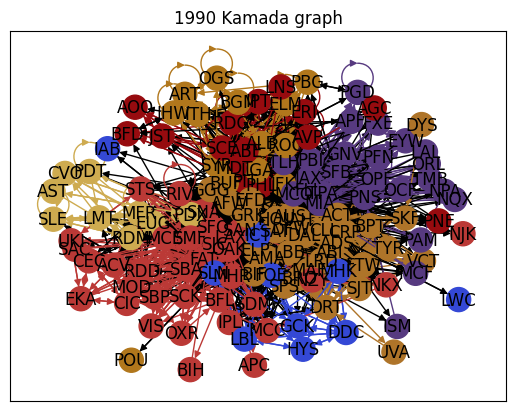

In [ ]:
posKBase = nx.kamada_kawai_layout(G)
nx.draw_networkx_edges(G, pos = posKBase, edge_color = edge_colors);
nx.draw_networkx_nodes(G, pos = posKBase, node_color = node_colors);
nx.draw_networkx_labels(G, pos = posKBase);
plt.title("1990 Kamada graph");

In [ ]:
KamadaPos = nx.kamada_kawai_layout(G)
KamadaPos = pd.Series(KamadaPos)
xVals, yVals = zip(*KamadaPos)
coordsK = pd.DataFrame({
    'xVals' : xVals,
    'yVals' : yVals
})

coordsK.index = list(G.nodes())

from sklearn.decomposition import PCA
import numpy as np

#combines the x and y coordinates into 1 values
pca = PCA(n_components=1)
y_pca = pca.fit_transform(coordsK)
coordsK = pd.Series(y_pca.flatten())
coordsK.index = list(G.nodes())

In [ ]:
SpringPos = nx.spring_layout(G)
SpringPos = pd.Series(SpringPos)
xVals, yVals = zip(*SpringPos)
coordsS = pd.DataFrame({
    'xVals' : xVals,
    'yVals' : yVals
})

coordsS.index = list(G.nodes())

from sklearn.decomposition import PCA
import numpy as np

#combines the x and y coordinates into 1 values
pca = PCA(n_components=1)
y_pca = pca.fit_transform(coordsS)
coordsS = pd.Series(y_pca.flatten())
coordsS.index = list(G.nodes())


In [ ]:
# coordsS.index = list(dict(airport_state).values())
# coordsS.sort_values()

In [ ]:
coordsS.index = list(G.nodes())

# Two Column SD Graphs

In [ ]:
# # Given data, the airport_state dict, and the stateSet creates a graph depicting
# # the flights between the states in stateSet throughtout every year in data with
# # distinctions made between source airports and destination airports

# #def makeBaseGraphSD(sample, airport_state, arpt_count, stateSet):
# G2 = nx.DiGraph()

# # creates graph with positions of source on x-val = 0 dest x-val = 1
# # y-val are determined by airport
# posSD = {}
# def add_edge_SD(row):

#         G2.add_edge(row['Origin_airport'] + '_S', row['Destination_airport'] + '_D')
#         posSD[row['Origin_airport'] + '_S']      = [0, coordsS[row['Origin_airport']]]
#         posSD[row['Destination_airport'] + '_D'] = [400, coordsS[row['Destination_airport']]]

# _ = sample.apply(add_edge_SD, axis=1)



In [ ]:
# colors = list(get_colors(len(states)))
# i = 0
# colorMap = {}
# for state in states:
#     colorMap[state] = colors[i]
#     i += 1

# # Creates a list of colors based upon the order of the nodes in the graph
# # and the state they correlate to
# node_colors = []
# for n in G2.nodes():
#     if n[:3] not in airport_state:
#         continue
#     node_colors.append(colorMap[airport_state[n[:3]]])

# edge_colors2 = []
# for edge in G2 .edges():
#   source = airport_state[edge[0][:3]]
#   dest   = airport_state[edge[1][:3]]
#   if source==dest:
#     edge_colors2.append(colorMap[source])
#   else:
#     edge_colors2.append("#000000")


In [ ]:
# fig = plt.figure(1, figsize=(30, 50), dpi=60)
# state_labels = {state: f'{state} ({color})' for state, color in colorMap.items()}
# legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, label=label)
#                   for label, color in colorMap.items()]
# plt.legend(handles=legend_handles, loc='upper right', prop = {'size': 30}, markerscale = 5)

# nx.draw_networkx_edges(G2, pos = posSD, edge_color = edge_colors2, width = 2.65);
# nx.draw_networkx_nodes(G2, pos = posSD, node_color = node_colors, node_size = 1000);
# nx.draw_networkx_labels(G2, pos = posSD);
# plt.title("1990 SD spring graph");

In [ ]:
# for key, val in posSD.items():
#   posSD[key][1] = coordsK[key[:3]]

In [ ]:
# fig = plt.figure(1, figsize=(30, 50), dpi=60)
# state_labels = {state: f'{state} ({color})' for state, color in colorMap.items()}
# legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, label=label)
#                   for label, color in colorMap.items()]
# plt.legend(handles=legend_handles, loc='upper right', prop = {'size': 30}, markerscale = 5)

# fig = plt.figure(1, figsize=(30, 45), dpi=60)
# nx.draw_networkx_edges(G2, pos = posSD, edge_color = edge_colors2, width = 2.65);
# nx.draw_networkx_nodes(G2, pos = posSD, node_color = node_colors, node_size = 1000);
# nx.draw_networkx_labels(G2, pos = posSD);
# plt.title("1990 SD Kamada graph");

In [ ]:
# Given data, the airport_state dict, and the stateSet creates a graph depicting
# the flights between the states in stateSet during a specific year.
# New nodes are essentailly made for each month in the year, and
# positioning is based on the month (x-val) and the airport (y-val)

# makes a graph as well as the coordinates (pos) of each node
GYear = nx.DiGraph()
posYear = {}
def add_edge(row):
  year = int(row['Year'])
  # print(year, row['Source_state'], row['Dest_state'])
  if not(((year>=1998 and year<=2002) and (row['Source_state'] == 'NY' and row["Dest_state"] == 'NY'))):
    # print('$$$$$$$$$$$$$$$')
    sourceArpt = row['Origin_airport']
    destArpt   = row['Destination_airport']

    #creates node names
    sourceNode = '%s_%s' % (sourceArpt, year)
    destNode   = '%s_%s' % (destArpt, year + 1)
    GYear.add_edge(sourceNode, destNode)

    # Each nodes x coordinate is determined by the month of the flight
    # However, the y coordinate is consistent but random/not purposeful
    posYear[sourceNode] = [year, arpt_count[sourceArpt]]
    posYear[destNode] = [year + 1, arpt_count[destArpt]]

_ = sample.apply(add_edge, axis=1)

In [ ]:
# #generates a random unique color for every state in stateSet
# colors = []
# cmap = plt.get_cmap('tab20')
# for i in range(len(states) // 2):
#     colors.append(cmap(i / (len(states) // 2)))

# # Generate second half of colors using HSL
# for i in range(len(states) // 2, len(states)):
#     hue = i / len(states)
#     lightness = 0.5
#     saturation = 0.8
#     rgb = colorsys.hls_to_rgb(hue, lightness, saturation)
#     colors.append(rgb)

# # Maps a unique color to each state
# i = 0
# colorMap = {}
# for state in states:
#   colorMap[state] = colors[i]
#   i += 1

# # Creates a list of colors based upon the order of the nodes in the graph
# # and the state they correlate to

# # removeOutliersKamada(GYear, posYear)

# node_colorsYear = []
# for n in GYear.nodes():
#   if (n[:3]) not in airport_state:
#     continue
#   node_colorsYear.append(colorMap[airport_state[n[:3]]])

# edge_colorsYear = []
# for edge in GYear.edges():
#   source = airport_state[edge[0][:3]]
#   dest   = airport_state[edge[1][:3]]
#   if source==dest:
#     edge_colorsYear.append(colorMap[source])
#   else:
#     edge_colorsYear.append("#000000")

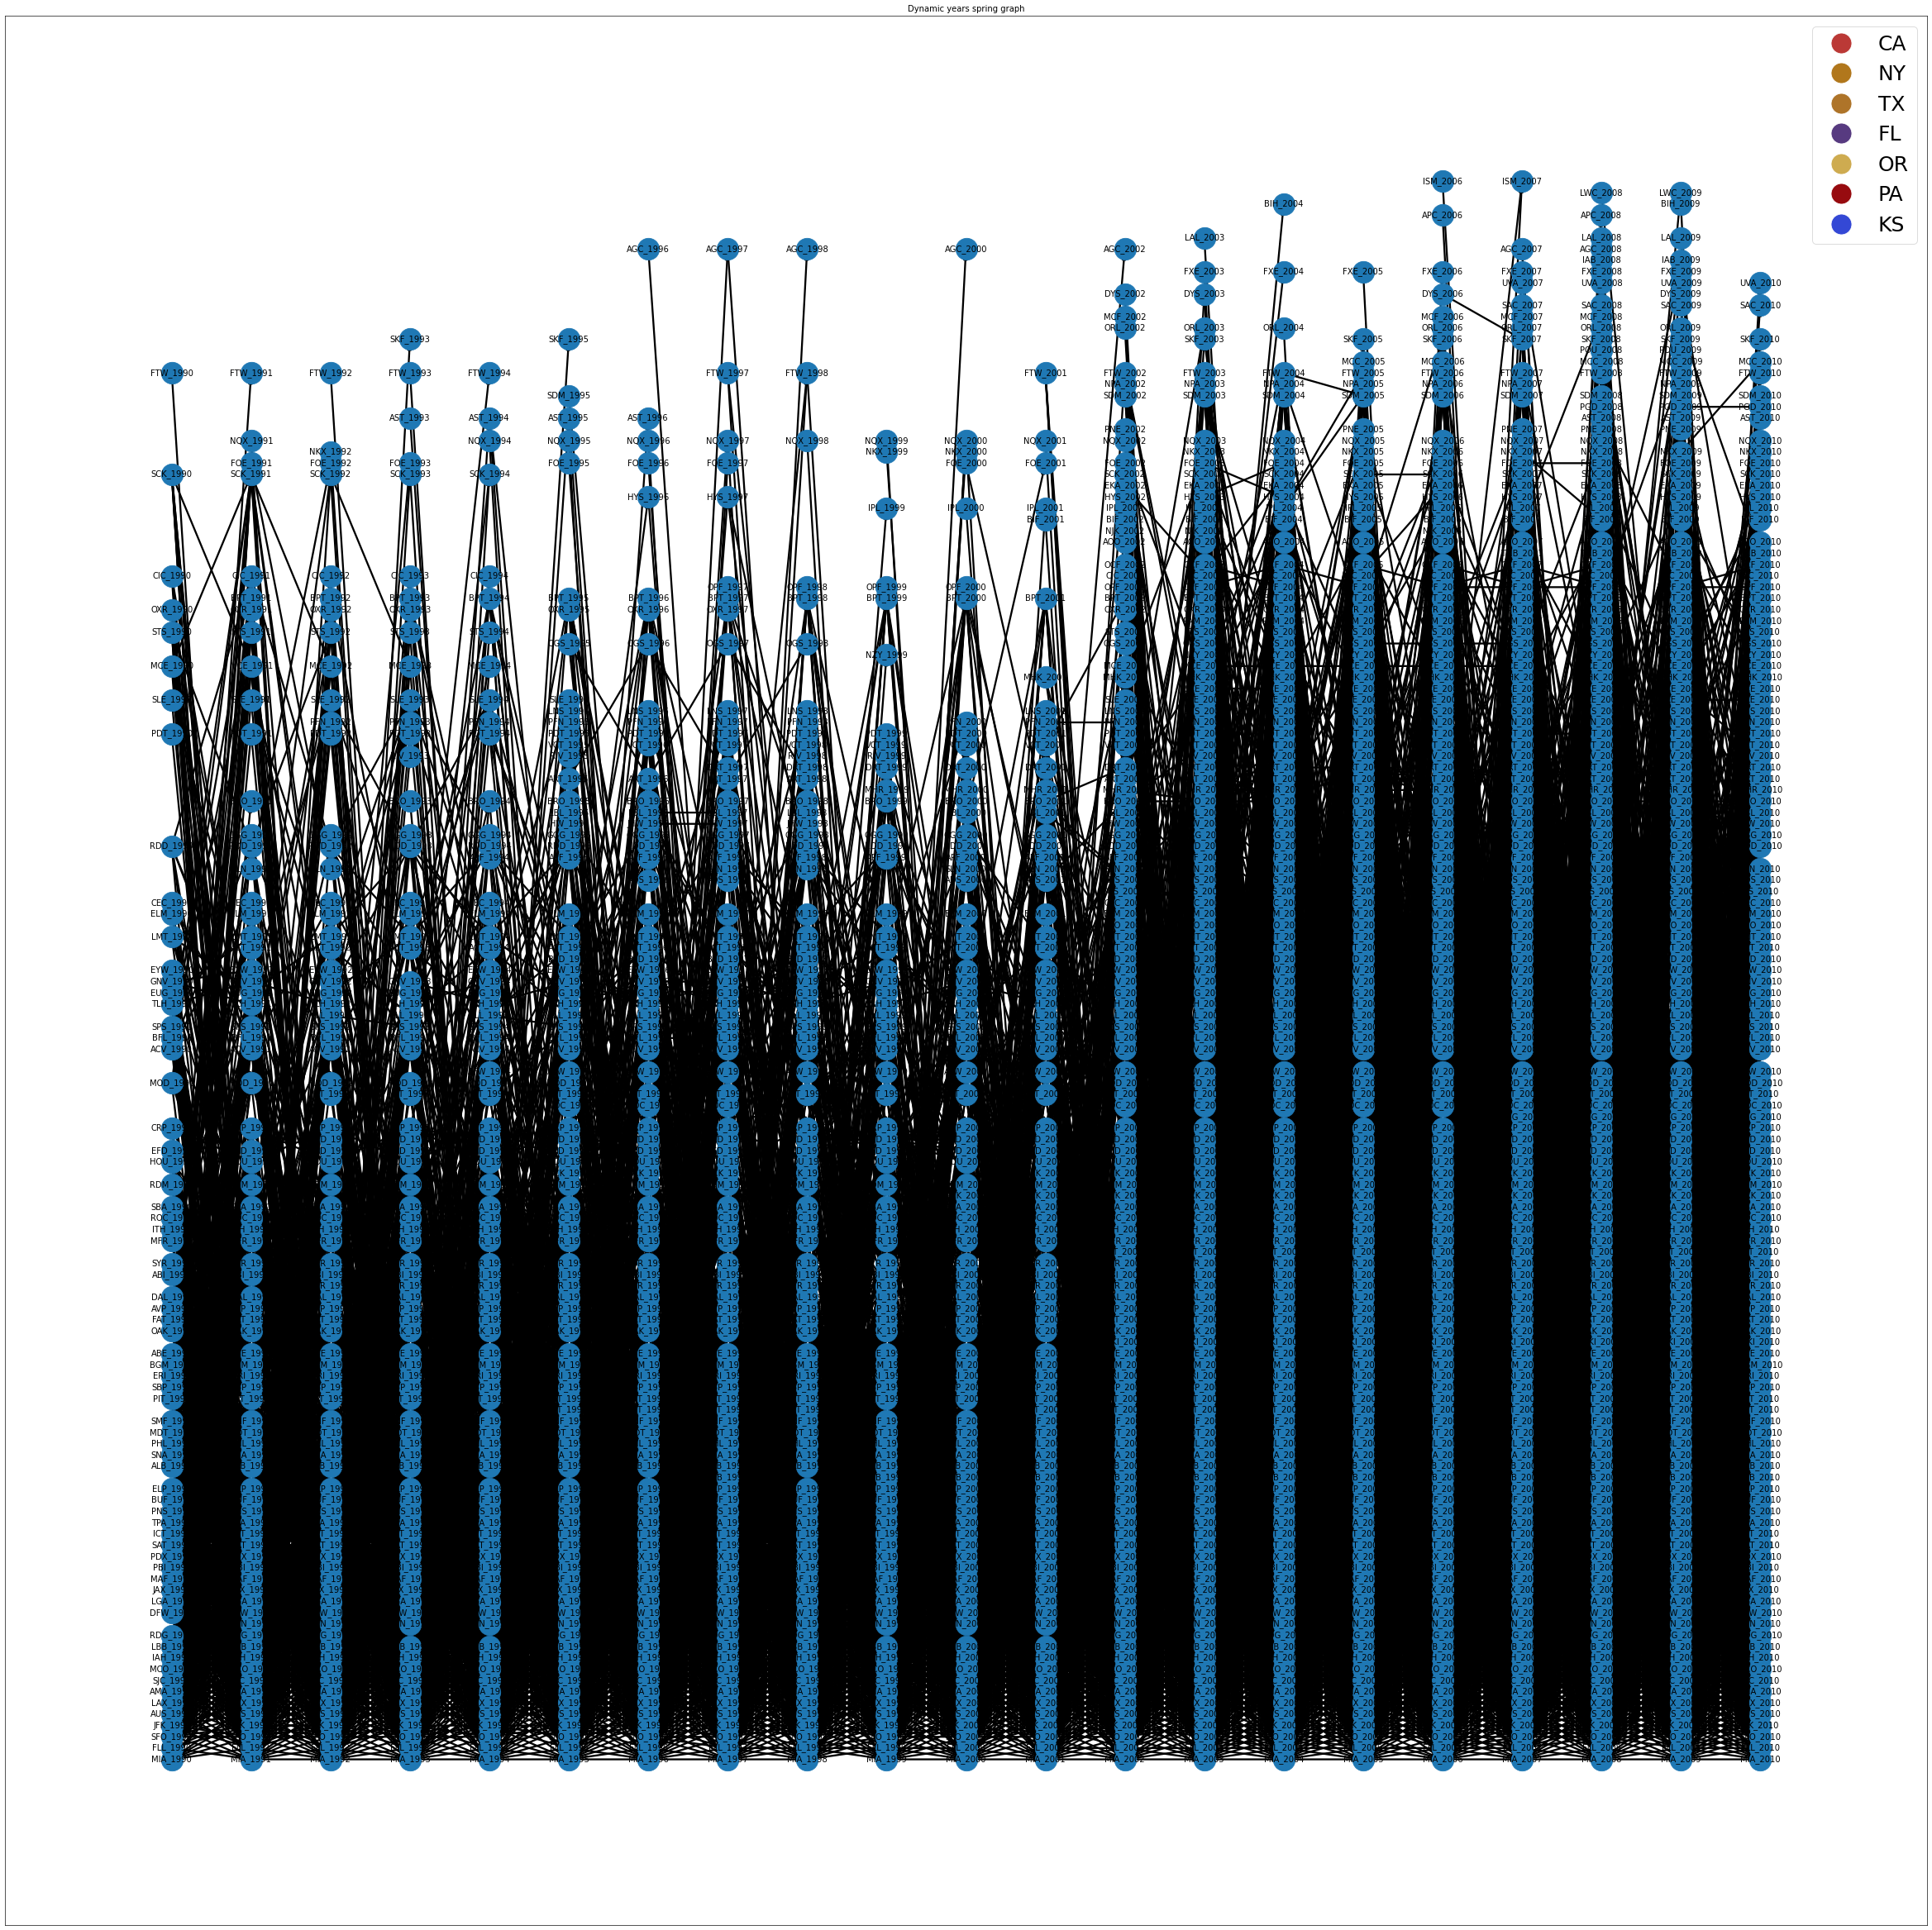

In [ ]:
fig = plt.figure(1, figsize=(50, 50), dpi=60)
state_labels = {state: f'{state} ({color})' for state, color in colorMap.items()}
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, label=label)
                  for label, color in colorMap.items()]
plt.legend(handles=legend_handles, loc='upper right', prop = {'size': 30}, markerscale = 5)

nx.draw_networkx_edges(GYear, pos = posYear, width = 2.75);
nx.draw_networkx_nodes(GYear, pos = posYear, node_size = 1000);
nx.draw_networkx_labels(GYear, pos = posYear);
plt.title("Dynamic years spring graph");

In [ ]:
# fig = plt.figure(1, figsize=(30, 50), dpi=60)
# state_labels = {state: f'{state} ({color})' for state, color in colorMap.items()}
# legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, label=label)
#                   for label, color in colorMap.items()]
# plt.legend(handles=legend_handles, loc='upper right', prop = {'size': 30}, markerscale = 5)
# fig = plt.figure(1, figsize=(50, 50), dpi=60)
# nx.draw_networkx_edges(GYear, pos = posYear, edge_color = edge_colorsYear, width = 2.75);
# nx.draw_networkx_nodes(GYear, pos = posYear, node_color = node_colorsYear, node_size = 1000);
# nx.draw_networkx_labels(GYear, pos = posYear);
# plt.title("Dynamic years spring graph");



In [ ]:
sourceStates = []
destStates   = []
year = []

for s, d in list(GYear.edges()):
  sourceStates.append(airport_state[s[:3]])
  destStates.append(airport_state[d[:3]])
  year.append(int(s[4:]))

GYearDF = pd.DataFrame({
    'Source State' : sourceStates,
    'Dest State' : destStates,
    'Year' : year,
})

cond = ((GYearDF['Source State'] == 'NY') & (GYearDF["Dest State"] == 'NY')) & ((GYearDF['Year'] >= 1998) & (GYearDF['Year'] <= 2002))
GYearDF = GYearDF[cond]
GYearDF

Empty DataFrame
Columns: [Source State, Dest State, Year]
Index: []

In [ ]:
# tmp = pd.DataFrame([(k.split('_')[0], posYear[k][1]) for k in posYear]).drop_duplicates()

# tmp2 = pd.merge(tmp, airport_state, left_on=0, right_index=True)
# airport_state

# tmp2.sort_values(1)

In [ ]:
for key, val in posYear.items():
  posYear[key][1] = coordsK[key[:3]]

In [ ]:
# dic = dict(airport_state)
# for key, val in airport_state.items():

#   print(key, val)
#for a 5 year stint in the middle no in state flights for new york, double the flights from new york to california,

'\nClustering looks better in Spring, but Kamada is less concentrated\n'

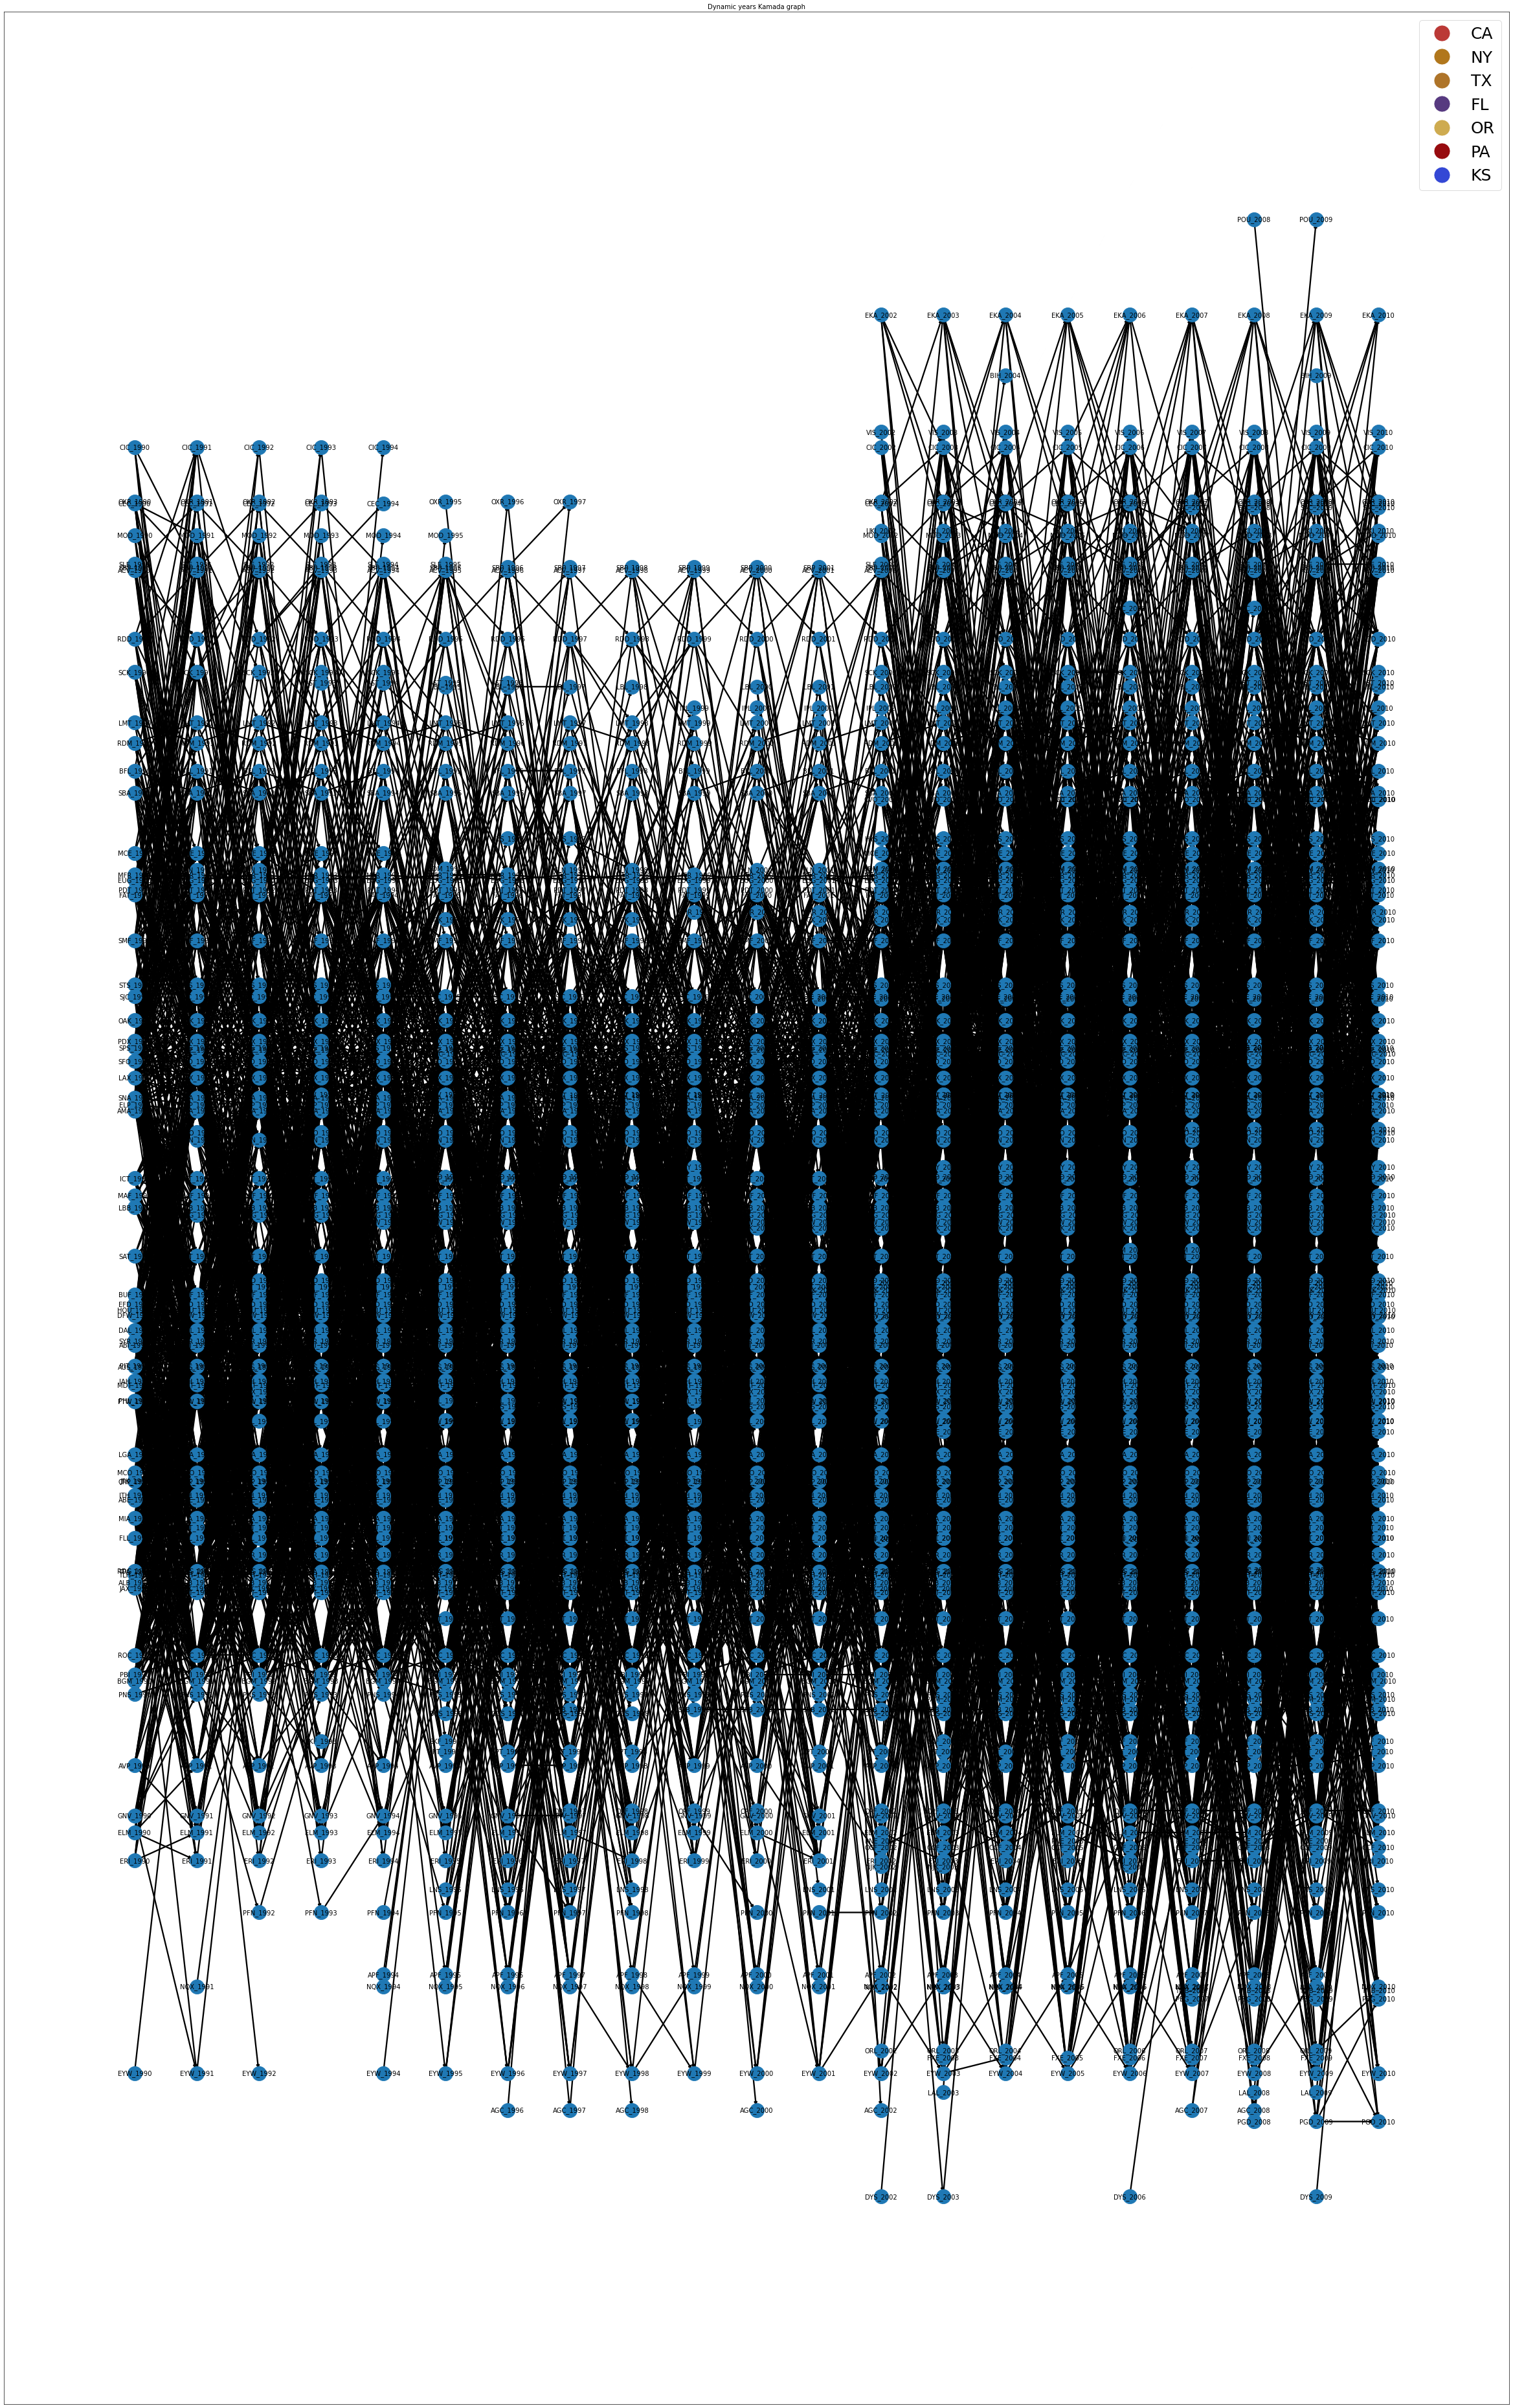

In [ ]:
fig = plt.figure(1, figsize=(50, 80), dpi=60)
state_labels = {state: f'{state} ({color})' for state, color in colorMap.items()}
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, label=label)
                  for label, color in colorMap.items()]
plt.legend(handles=legend_handles, loc='upper right', prop = {'size': 30}, markerscale = 5)

nx.draw_networkx_edges(GYear, pos = posYear, width = 2.75);
nx.draw_networkx_nodes(GYear, pos = posYear, node_size = 700);
nx.draw_networkx_labels(GYear, pos = posYear);
plt.title("Dynamic years Kamada graph");
"""
Clustering looks better in Spring, but Kamada is less concentrated
"""